In [2]:
import pandas as pd
import numpy as np
import os
import sys
import datetime
import time

#from netCDF4 import Dataset, num2date
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.multioutput import MultiOutputRegressor

import matplotlib.dates as mdates
import matplotlib.colors
import matplotlib.ticker as ticker

from pysolar.solar import *
import pytz
import shap
import pickle
import multiprocessing


# Perameters


In [3]:
cheap_node_id = '001e06305a6b'
node_id = '10004098'
gps_node_id = '001e0610c2e9'
dir_out = '../figures/'
dir_data = '../data/'

years = ['2019','2020'] ####
months = ['1','2','3','4','5','6','7','8','9','10','11','12']
days = np.array(range(1,31+1)).astype(str) #### np.array(range(1,31+1)).astype(str)
days = list(days)

hours = (np.array(range(0,24))).astype(str)
hours = list(hours)

bins = np.array(range(0,420+1)).astype(str)
bins = list(bins)
for i in range(len(bins)):
    bins[i] = 'Spectrum[' + bins[i] + ']'

wavelengths = np.array(range(360,780+1)).astype(str)
for i in range(len(wavelengths)):
    wavelengths[i] = wavelengths[i] + 'nm'
wavelengths = list(wavelengths)

## Read Data

In [4]:
# if data has been preprocessed before, run this directly
fn_data = dir_data + node_id + '_'+ cheap_node_id +'.csv'
df = pd.read_csv(fn_data, parse_dates=True, index_col = 'UTC')


## Data  For Training

In [11]:
print(df.columns[:41]) # the last is UV Index
print('Variable Numbers in cheap sensors: 41')
print('Sample Numbers: ',len(df))

Index(['cloudPecentage', 'allRed', 'allGreen', 'allBlue', 'skyRed', 'skyGreen',
       'skyBlue', 'cloudRed', 'cloudGreen', 'cloudBlue', 'Violet', 'Blue',
       'Green', 'Yellow', 'Orange', 'Red', 'Temperature', 'Pressure',
       'Humidity', 'Latitude', 'Longitude', 'Altitude', 'NH3', 'CO', 'NO2',
       'C3H8', 'C4H10', 'CH4', 'H2', 'C2H5OH', 'c02', 'Luminosity', 'IR',
       'Full', 'Visible', 'Lux', 'UVA', 'UVB', 'Visible Compensation',
       'IR Compensation', 'UV Index'],
      dtype='object')
Variable Numbers in cheap sensors: 41
Sample Numbers:  144918


# Model Start from here

## Model for Whole Spectrum

In [24]:
features = np.append(df.columns[:41], ['Zenith'])
targets = df.columns[41+1:-1].values # skip Illuminance, keep Wavelengths
print(features)
print(targets[[1,-1]])

X = df[features]
Y = df[targets]


['cloudPecentage' 'allRed' 'allGreen' 'allBlue' 'skyRed' 'skyGreen'
 'skyBlue' 'cloudRed' 'cloudGreen' 'cloudBlue' 'Violet' 'Blue' 'Green'
 'Yellow' 'Orange' 'Red' 'Temperature' 'Pressure' 'Humidity' 'Latitude'
 'Longitude' 'Altitude' 'NH3' 'CO' 'NO2' 'C3H8' 'C4H10' 'CH4' 'H2'
 'C2H5OH' 'c02' 'Luminosity' 'IR' 'Full' 'Visible' 'Lux' 'UVA' 'UVB'
 'Visible Compensation' 'IR Compensation' 'UV Index' 'Zenith']
['361nm' '780nm']


In [25]:
# train test datasets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0) 
print(len(X_train))


115934


In [26]:
RANDOM_STATE = 42
n_jobs = multiprocessing.cpu_count()
n_jobs


8

In [29]:
X_train_sample, _, Y_train_sample, _ = train_test_split(X_train, Y_train, test_size=0.99, random_state=0) 


In [27]:
# start_time = time.time()

# # Random Forest Model, grid search to find best parameter
# RANDOM_STATE = 42
# rfr =  MultiOutputRegressor(RandomForestRegressor(random_state = RANDOM_STATE, oob_score=True, n_jobs = -1))
# param_grid = {'max_depth': [20,30],'n_estimators': [50,100]}
# CV_rfr = GridSearchCV(estimator = rfr, param_grid = param_grid, cv =5, verbose = 3)

# CV_rfr.fit(X_train_sample, Y_train_sample)
# print(CV_rfr.best_params_)
# print(CV_rfr.best_score_)
# print("--- %s seconds ---" % (time.time() - start_time))

In [30]:
max_depth = 30
n_estimators = 50
start_time = time.time()
regr = MultiOutputRegressor(RandomForestRegressor(random_state = RANDOM_STATE,
                             max_depth = max_depth,
                             n_estimators = n_estimators,
                             n_jobs = n_jobs))
regr.fit(X_train_sample, Y_train_sample)

print("--- %s seconds ---" % (time.time() - start_time))

--- 101.04359698295593 seconds ---


In [31]:
fn_model = '../models/multiRF_whole_dep'+str(max_depth)+'_ne'+str(n_estimators)+'.sav'
pickle.dump(regr, open(fn_model, 'wb'))

In [33]:
from sklearn.metrics import r2_score
r2_score(Y_train_sample[:5],regr.predict(X_train_sample[:5]))


0.9514534178644332

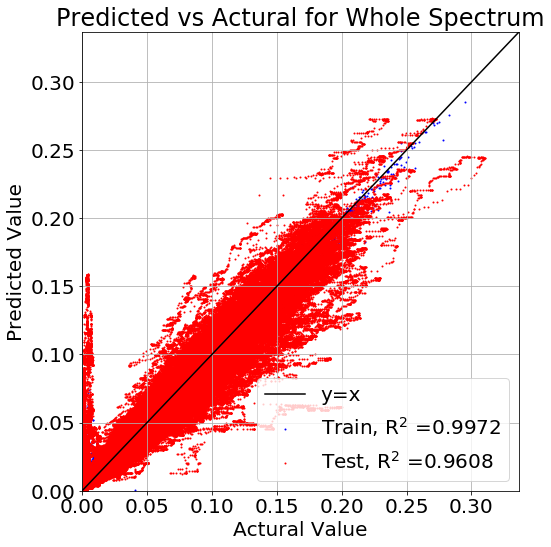

In [35]:
from sklearn.metrics import r2_score
train_score = r2_score(y_train_sample,regr.predict(X_train_sample))
test_score = r2_score(y_test,regr.predict(X_test))

y_min = np.min(y_train)
y_max = np.max(y_train)
y_line = np.linspace(y_min,y_max,100)

plt.rcParams["figure.figsize"] = (8, 8) # (w, h)
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots()
plt.plot(y_line,y_line, '-k', label='y=x')
plt.scatter(y_train_sample,regr.predict(X_train_sample), s=1, c = 'blue',label = 'Train, R$^{2}$ ='+str(train_score)[:6])
plt.scatter(y_test,regr.predict(X_test), s=1, c = 'red', label = 'Test, R$^{2}$ ='+str(test_score)[:6])
plt.xlim((y_min,y_max))
plt.ylim((y_min,y_max))
ax.set_title('Predicted vs Actural for Whole Spectrum')
ax.set_xlabel('Actural Value')
ax.set_ylabel('Predicted Value')
plt.legend( loc='lower right')
plt.grid()
plt.tight_layout()
plt.savefig(dir_out +'multiRF_performance_whole_dep'+str(max_depth)+'_ne'+str(n_estimators)+'.png')


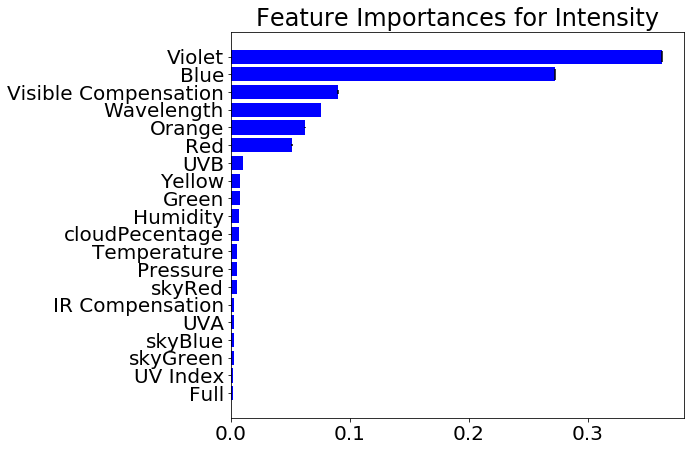

In [36]:
# rank feature inportance
num_features = 20
importances = regr.feature_importances_
std = np.std([tree.feature_importances_ for tree in regr.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

var_sorted = features_expand[indices]
var_imp_sorted = importances[indices]

plt.rcParams["figure.figsize"] = (10, num_features/3) # (w, h)
fig, ax = plt.subplots()
ax.barh(var_sorted[:num_features], var_imp_sorted[:num_features],
        yerr=std[indices][:num_features], ecolor='black',
        color = 'blue', align="center")
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_title('Feature Importances for ' + target_name)
plt.tight_layout()
plt.savefig(dir_out +'multiRF_feature_imp_whole_dep'+str(max_depth)+'_ne'+str(n_estimators)+'.png')

In [ ]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(regr)
# Calculate shap_values
num_shap = 500
shap_values = explainer.shap_values(X_train[:num_shap])

In [ ]:
# plot
shap.summary_plot(shap_values, X_train[:num_shap],
                  plot_size=(10,8),#'auto'
                  max_display = 20,
                  show=False
                 )
plt.tight_layout()
plt.savefig(dir_out + 'multiRF_shap_whole_dep'+str(max_depth)+'_ne'+str(n_estimators)+'.png')

## Compare Full Spectrum with Prediction

In [78]:
year = 2019
month = 12
day = 31
hour = 11+6
jetlag = 6
date_string = '%04d-%02d-%02d %02d:00:00' % (year, month, day, hour)

In [79]:
iwant = (X.index == date_string)

In [80]:
wavelengths = np.array(range(360,780+1))

x1 = X[iwant].index.values
y1 = y[iwant].values
y1_pred = regr.predict(X[iwant])

In [81]:
fig, ax = plt.subplots(constrained_layout=True, figsize=(16, 8))
spectrum = y1
h = ax.plot(wavelengths, spectrum)

plt.plot(wavelengths, spectrum)

y2 = np.linspace(0, np.max(spectrum)*1.1, 100)

XX,YY = np.meshgrid(wavelengths, y)
XX[XX<400] = 400
extent=(np.min(wavelengths), np.max(wavelengths), np.min(y2), np.max(y2))

plt.imshow(XX, clim=(350,780),  extent=extent, cmap=spectralmap, aspect='auto')
plt.fill_between(wavelengths, spectrum, np.max(spectrum)*1.1, color='w')
ax.set_title('Spectrum: %02d/%02d/%02d %02d:00' % (year, month, day, hour-jetlag), fontsize=40)
ax.set_xlabel('Wavelength / nm',fontsize=30)
ax.set_ylabel('Intensity',fontsize=30)

fig.savefig(dir_out+'Spectrum_%02d_%02d_%02d_%02d.png' % (year, month, day, hour-jetlag))
plt.close()

In [82]:
fig, ax = plt.subplots(constrained_layout=True, figsize=(16, 8))
spectrum = y1_pred
h = ax.plot(wavelengths, spectrum)

plt.plot(wavelengths, spectrum)

y2 = np.linspace(0, np.max(spectrum)*1.1, 100)

XX,YY = np.meshgrid(wavelengths, y)
XX[XX<400] = 400
extent=(np.min(wavelengths), np.max(wavelengths), np.min(y2), np.max(y2))

plt.imshow(XX, clim=(350,780),  extent=extent, cmap=spectralmap, aspect='auto')
plt.fill_between(wavelengths, spectrum, np.max(spectrum)*1.1, color='w')
ax.set_title('Predicted Spectrum: %02d/%02d/%02d %02d:00' % (year, month, day, hour-jetlag), fontsize=40)
ax.set_xlabel('Wavelength / nm',fontsize=30)
ax.set_ylabel('Intensity',fontsize=30)

fig.savefig(dir_out+'Spectrum_%02d_%02d_%02d_%02d_pred.png' % (year, month, day, hour-jetlag))
plt.close()